# EOF Example with CMAP precipitation data

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from clim_utils import reshape

In [2]:
file='/homes/jcampb8/data-shell/thesis/enso4_1979-2018.cmap.monthly.precip.mon.mean.nc'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 480)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    version:        V1912
    history:        update 12/2019 V1912
    data_modified:  2019-12-12

### Make anomalies

In [3]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 480)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 -0.20839843 -0.12617189 ... 0.44726562

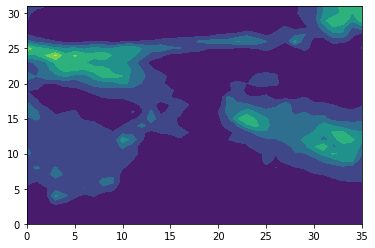

In [4]:
plt.contourf(ds['precip'][0,:,:])
###EOF analysis CANNOT have any NAN values in data set

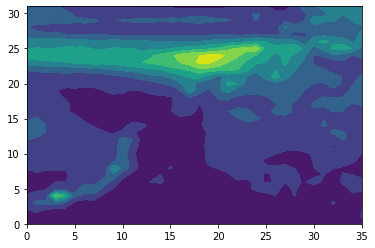

In [5]:
plt.contourf(ds['precip'].std(dim='time'))

In [6]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

#### Plot Precip over my Designated region (-10,70,160,300)

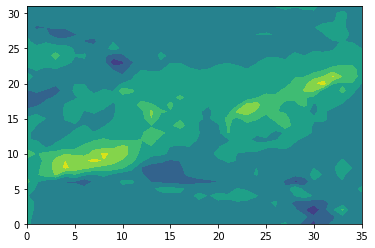

In [7]:
ds_tpac=ds_anoms
plt.contourf(ds_tpac['precip'][0,:,:])

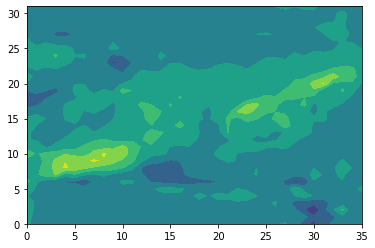

In [8]:
coslat=np.cos(np.deg2rad(ds_tpac.coords['lat'].values))
wgts=np.sqrt(coslat)[...,np.newaxis]
wgts.shape

ds_tpac=ds_tpac*wgts
plt.contourf(ds_tpac['precip'][0,:,:])

### Reshape to [time,space]

In [11]:
nx=len(ds_tpac['lon'])
ny=len(ds_tpac['lat'])
nt=len(ds_tpac['time'])

In [12]:
X=np.reshape(ds_tpac['precip'].values,((nt,ny*nx)))
X.shape

(480, 1152)

## Calculate EOFs
### Calculate the Covariance Matrix
$C[space,space]=X^T[space,time] X[time,space]$

$C[time,time]=X^T[time,space] X[space,time]$

#### To remove 1/N part of covariance,
C=np.matul(X.T,X) 

In [13]:
C=np.cov(X)
C.shape

(480, 480)

In [14]:
from numpy import linalg as LA

In [15]:
eigenvalues, eigenvectors = LA.eig(C)

In [16]:
idx=eigenvalues.argsort()[::-1] # descending order, most lavriance to least variance
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

## Get the PC Time Series

In [17]:
eigenvectors.shape

(480, 480)

In [18]:
PC=eigenvectors

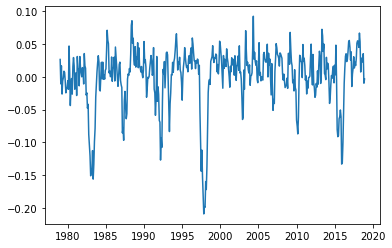

In [19]:
plt.plot(ds_anoms['time'],PC[:,0])

### Eof Spatial Patterns

In [20]:
EOF=np.dot(X.T,PC)
EOF.shape

(1152, 480)

# To find and replace NAN values for EOF analysis
### `np.isnan()`

### set NANs to -9999.0
### `np.where`

In [21]:
EOF=EOF.reshape((ny,nx,nt))
EOF.shape

(32, 36, 480)

In [22]:
ny,nx,nt

(32, 36, 480)

In [23]:
EOF=np.dot(X.T,PC)
EOF=EOF.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF.shape

(480, 36, 32)

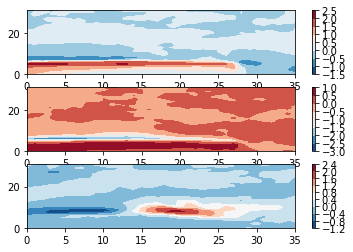

In [24]:
nrows=3
ncols=1
sf=[-1,-1,-1]
for i in np.arange(3):
    eofnorm=EOF[i,:,:].T*np.std(PC[:,i])
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(eofnorm*sf[i],cmap='RdBu_r')
    plt.colorbar()

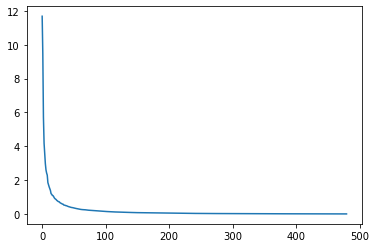

In [25]:
vexp=eigenvalues/np.sum(eigenvalues)*100
plt.plot(vexp)

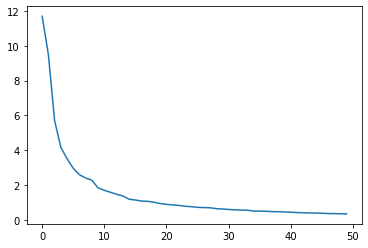

In [26]:
plt.plot(vexp[0:50])

In [27]:
vexp[0:10]

array([11.68713479,  9.4838757 ,  5.71092126,  4.18023343,  3.52482199,
        2.97485524,  2.60479598,  2.41661974,  2.29227901,  1.8502975 ])

In [28]:
np.sum(vexp[0:71]) #Usually try to pick 90% of variance

82.40023142114367

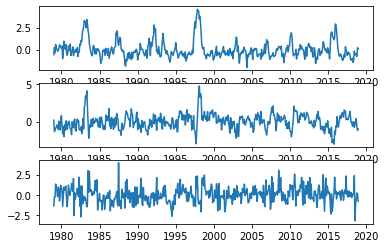

In [29]:
for i in np.arange(3):
    pcnorm=PC[:,i]/np.std(PC[:,i])
    plt.subplot(nrows,ncols,i+1)
    plt.plot(ds_anoms['time'],pcnorm*sf[i])
# These are usually shown together with spatial pattern plots above
# Theses are called time series plots (normalized by standard deviation)